<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Discrete-areas" data-toc-modified-id="Discrete-areas-1">Discrete areas</a></span><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1.1">Prepare data</a></span></li><li><span><a href="#Points-to-h3-indexes" data-toc-modified-id="Points-to-h3-indexes-1.2">Points to h3 indexes</a></span></li><li><span><a href="#Choropleth-map" data-toc-modified-id="Choropleth-map-1.3">Choropleth map</a></span></li><li><span><a href="#Interactive-map" data-toc-modified-id="Interactive-map-1.4">Interactive map</a></span></li><li><span><a href="#Points-per-area" data-toc-modified-id="Points-per-area-1.5">Points per area</a></span></li></ul></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-2">Data cleaning</a></span><ul class="toc-item"><li><span><a href="#Noise" data-toc-modified-id="Noise-2.1">Noise</a></span></li><li><span><a href="#Detect-outliers" data-toc-modified-id="Detect-outliers-2.2">Detect outliers</a></span></li><li><span><a href="#Remove-outliers" data-toc-modified-id="Remove-outliers-2.3">Remove outliers</a></span><ul class="toc-item"><li><span><a href="#Discussion" data-toc-modified-id="Discussion-2.3.1">Discussion</a></span></li><li><span><a href="#Algorithm" data-toc-modified-id="Algorithm-2.3.2">Algorithm</a></span></li><li><span><a href="#Removal" data-toc-modified-id="Removal-2.3.3">Removal</a></span></li></ul></li></ul></li><li><span><a href="#Export-data" data-toc-modified-id="Export-data-3">Export data</a></span></li></ul></div>

# Discrete areas

Coordinates in the dataset are continuous variables. As we will see below, there are different demand patterns in different parts of the city. In some areas demand is abnormally high or abnormally low for short periods of time. It's not possible to remove such outliers on individual points level but such locations can be identified if points are grouped by some regions. In addition, a region can be a good feature for predictions.

The discrete regions are created using [h3](https://h3geo.org/).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from h3 import h3

from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

import pandas as pd
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 20)
pd.set_option('precision', 3)

## Prepare data

In [55]:
%%time 

data = pd.read_feather('structured_data.feather')

data = data.sample(1000000)

data.head()

CPU times: user 5.43 s, sys: 8.83 s, total: 14.3 s
Wall time: 20.6 s


,datetime,lon,lat
60875772,2015-06-18 09:19:22,-73.964,40.765
26522107,2015-03-15 02:31:01,-73.989,40.722
53427810,2015-05-28 11:00:01,-74.011,40.712
61662708,2015-06-20 11:57:47,-73.989,40.748
41199654,2015-04-23 21:37:03,-73.955,40.769


## Points to h3 indexes

In [56]:
%%time


def point_h3_indexes(points: pd.DataFrame, res: int) -> np.ndarray:
    """Create h3 indexes for each lat-lon pair in points"""

    h3_indexes = points.apply(
        lambda point: h3.geo_to_h3(point['lat'], point['lon'], res),
        axis=1
    )
    return h3_indexes


data['h3_res8'] = point_h3_indexes(data, 8)
data['h3_res9'] = point_h3_indexes(data, 9)

CPU times: user 1min 5s, sys: 825 ms, total: 1min 6s
Wall time: 1min 9s


## Choropleth map

Count the number of points per area and color hexagons according to the number

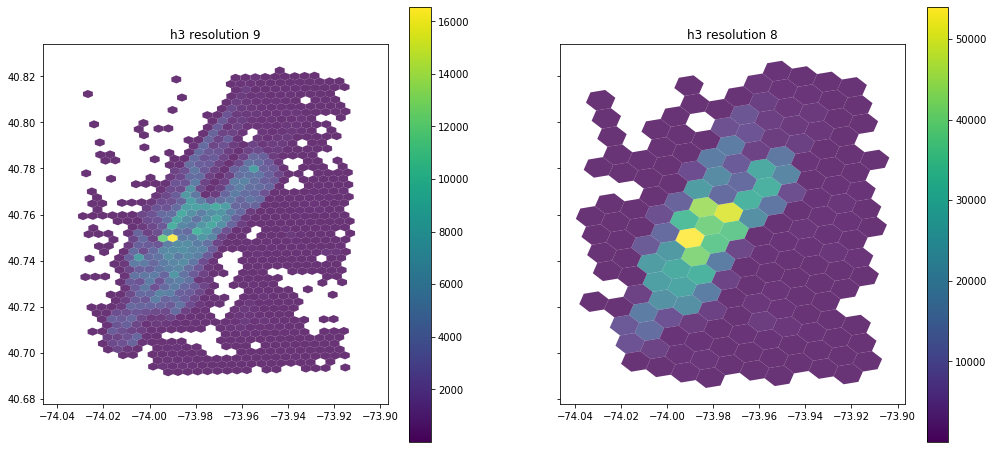

In [4]:
from shapely.geometry import Polygon
import geopandas as gpd


def h3_to_polygon(item) -> Polygon:
    """Convert h3 index to shapely polygon"""
    h3_index = item['index']
    boundary = h3.h3_to_geo_boundary(h3_address=h3_index, geo_json=True)
    return Polygon(boundary)


def plot_choropleth(data, title=None, ax=None):
    counts = data.value_counts()
    counts = counts.to_frame(name='total').reset_index()
    
    geo_df = gpd.GeoDataFrame(counts, geometry=counts.apply(h3_to_polygon, axis=1))
    geo_df.plot(column='total', alpha=0.8, legend=True, ax=ax);
    
    if title and ax:
        ax.set_title(title)
    elif title:
        plt.title(title)
    
fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)

plot_choropleth(data.h3_res9, 'h3 resolution 9', ax=ax1)
plot_choropleth(data.h3_res8, 'h3 resolution 8', ax=ax2);

## Interactive map

Create an interactive map using _folium_ to plot hexagons with different resolutions

In [5]:
import geojson
from geojson import FeatureCollection
import folium


def indexes_to_polygons(h3_indexes):
    polygons = []

    for h in h3_indexes:
        polygon = Polygon(h3.h3_to_geo_boundary(h3_address=h, geo_json=True))
        polygons.append(polygon)

    feature_collection = FeatureCollection(polygons)
    return geojson.dumps(feature_collection)


def create_style_fn(color, opacity=0.1, weight=2):
    """Ugly way to set color of json features"""

    return lambda feature: {
        'fillColor': None,
        'color': color,
        'weight': weight,
        'fillOpacity': opacity
    }


m = folium.Map(location=[40.7536, -73.9811], zoom_start=12)

# resolution 8
feature_collection = indexes_to_polygons(data.h3_res8.unique())
folium.GeoJson(
    feature_collection,
    style_function=create_style_fn('blue', opacity=0.1, weight=2),
).add_to(m)

# resolution 9
feature_collection = indexes_to_polygons(data.h3_res9.unique())
folium.GeoJson(
    feature_collection,
    style_function=create_style_fn('green', opacity=0., weight=1)
).add_to(m)

m

## Points per area

Plot distribution of number of points per each area

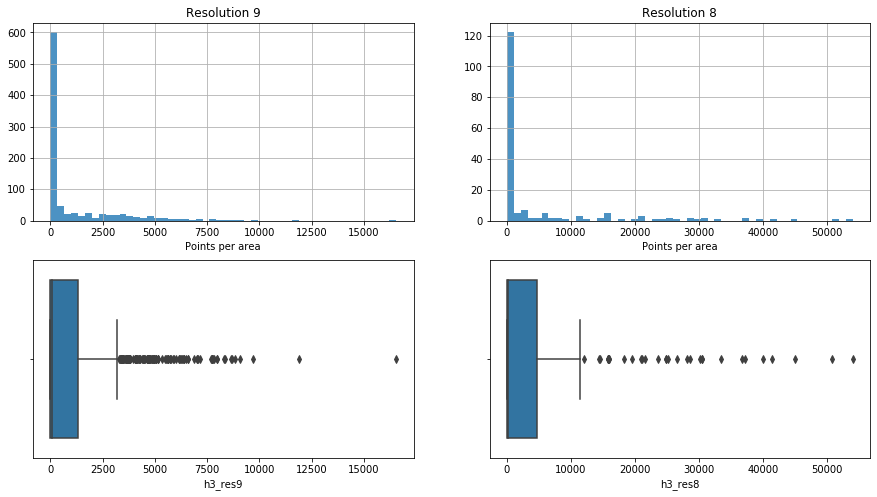

In [6]:
plt.figure(figsize=(15, 8))

plt.subplot(221)
plt.title('Resolution 9')
data.h3_res9.value_counts().hist(bins=50, alpha=0.8);
plt.xlabel('Points per area')

plt.subplot(223)
sns.boxplot(data.h3_res9.value_counts());

plt.subplot(222)
plt.title('Resolution 8')
data.h3_res8.value_counts().hist(bins=50, alpha=0.8);
plt.xlabel('Points per area')

plt.subplot(224)
sns.boxplot(data.h3_res8.value_counts());

Histograms how that the data is largely skewed to the right. It looks noise, let's check basic statistics of the data:

In [7]:
h9_total = data.h3_res9.value_counts().to_frame('total').reset_index()

h9_total.total.describe()

count      922.000
mean      1084.599
std       1961.964
min          1.000
25%          5.250
50%         58.000
75%       1318.500
max      16546.000
Name: total, dtype: float64

# Data cleaning

## Noise

More than half of the areas contain really small number of points. The question is what is _small_ and how to find a cut-off point that separate noise from somehow interesting data - areas where demand prediction makes sense, especially from business point of view (it doesn't make sense to consider areas where the total number of point is, for example, around hundred in 6 month whereas some area contain thousand of points per week).

As simple heuristic is to only consider areas where something happens every day - there are at least one point per day per area for the whole time range of the dataset.

Text(0.5, 0, 'Days')

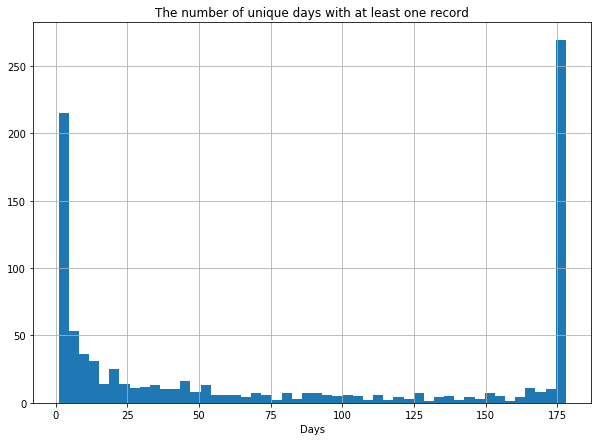

In [8]:
# count number of points per area per day
daily_total = data.groupby(['h3_res9', data.datetime.dt.date]).h3_res9.count()

# convert to dataframe
daily_total = daily_total.to_frame('total').reset_index()

# calculate aggregations
daily_agg = daily_total.groupby('h3_res9').agg({'total': ['count']})

# plot the number of unique days with at least one record
daily_agg.total['count'].hist(bins=50)

plt.title('The number of unique days with at least one record')
plt.xlabel('Days')

In [57]:
def remove_noise(data, res_column='h3_res9', tolerance=1) -> pd.DataFrame:
    """ Filter out regions with at least one day without any events. 

    The definition of a "good" region is a region where things happen every day.

    Params:
    ------

    data: pd.DataFrame

    res_column: str - a column with regions used for data grouping

    tolerance: int - allow small deviaton (total_dates +/- tolerance) assuming 
        that few days can be missing due to an error
    """

    # Unique dates from the dataset. There are can be some missing days due to
    # incomplete data or previois cleaning so the list of dates contains only
    # dates that are present in the dataset
    unique_dates = data.datetime.dt.date.unique()

    # count number of points per area per day
    daily_total = data.groupby([res_column,
                                data.datetime.dt.date]).h3_res9.count()

    # convert to dataframe
    daily_total = daily_total.to_frame('total').reset_index()

    # calculate aggregations
    daily_agg = daily_total.groupby(res_column).agg({'total': ['count']})

    outliers_index = daily_agg.total['count'] < (
        unique_dates.shape[0] - tolerance)

    # list of noisy areas
    outliers = daily_agg[outliers_index].index.tolist()

    return data[~data[res_column].isin(outliers)]


data_clean = remove_noise(data)
# data_clean = data[~data.h3_res9.isin(outliers)]

print('Original dataset:')
print('- size:', data.shape[0])
print('- number of areas', data.h3_res9.nunique())

print('\nClean dataset:')
print('- size:', data_clean.shape[0])
print('- number of areas', data_clean.h3_res9.nunique())

Original dataset:
- size: 1000000
- number of areas 948

Clean dataset:
- size: 935256
- number of areas 258


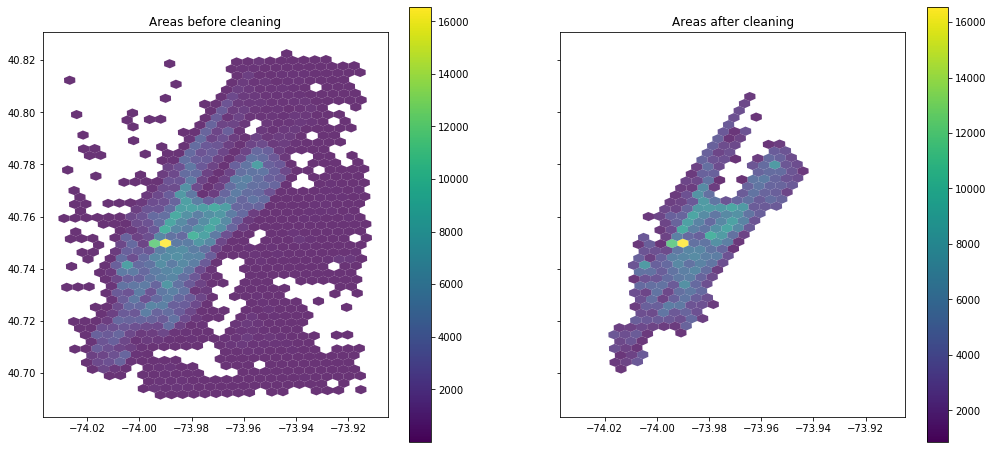

In [10]:
fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)

plot_choropleth(data.h3_res9, 'Areas before cleaning', ax=ax1)
plot_choropleth(data_clean.h3_res9, 'Areas after cleaning', ax=ax2)

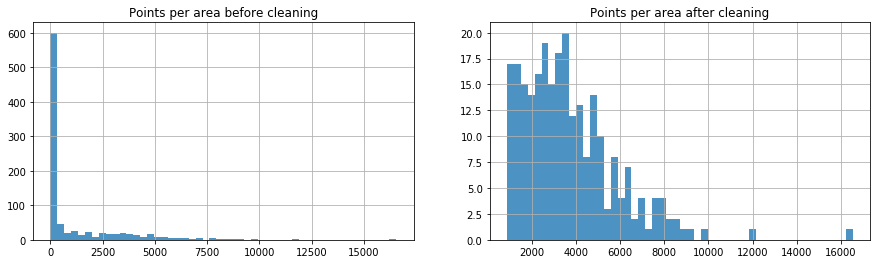

In [11]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.title('Points per area before cleaning')
data.h3_res9.value_counts().hist(bins=50, alpha=0.8);

plt.subplot(122)
plt.title('Points per area after cleaning')
data_clean.h3_res9.value_counts().hist(bins=50, alpha=0.8);

## Detect outliers

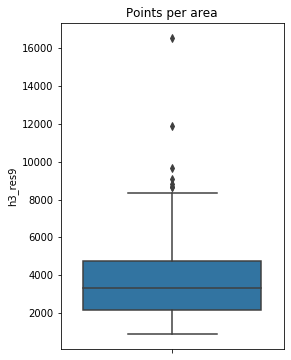

In [12]:
plt.figure(figsize=(4, 6))
sns.boxplot(data_clean.h3_res9.value_counts(), orient='v');

plt.title('Points per area');

There are few areas where the number of points is too high. It could be that:

- there are too many points per day in that areas
- there are some peak days with a large number of point per area

In the second case peak days can be removed from history of areas with high total number of points.

In [13]:
# count number of points per area per day
daily_total = data_clean.groupby(
    ['h3_res9', data.datetime.dt.date]).h3_res9.count()

# convert to dataframe
daily_total = daily_total.to_frame('total').reset_index()

daily_total.sample(5)

,h3_res9,datetime,total
28880,892a100d697ffff,2015-02-25,25
34088,892a107258fffff,2015-04-16,11
23527,892a100d60fffff,2015-02-12,37
15308,892a100d24fffff,2015-01-10,30
6307,892a1008987ffff,2015-03-26,11


Use MAD based method (explained in the exploration notebook) to detect outliers:

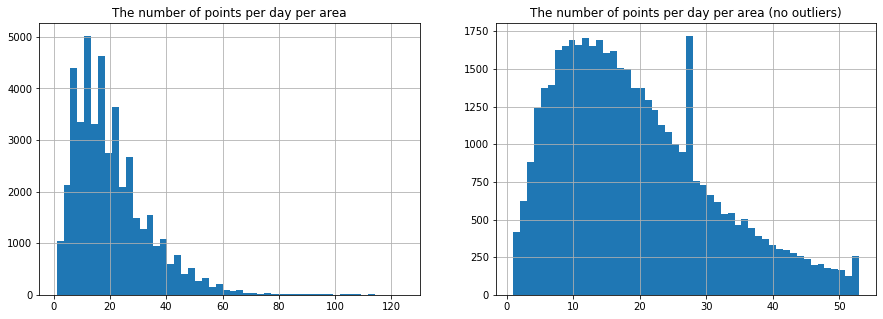

In [14]:
from tools import MAD_outliers

plt.figure(figsize=(15, 5))
plt.subplot(121)

daily_total.total.hist(bins=50);
plt.title('The number of points per day per area');

plt.subplot(122)
index_outliers = MAD_outliers(daily_total.total)
plt.title('The number of points per day per area (no outliers)');
daily_total.total[~index_outliers].hist(bins=50);

Now we can check if there are areas among outliers where the number of points per day for the whole time range is significantly higher than in other areas. To do this I plot the number of days with large number of points per area and show how far it from the maximum number of unique days:

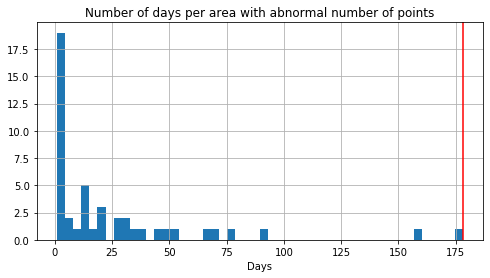

In [15]:
plt.figure(figsize=(8, 4))

daily_total[index_outliers].h3_res9.value_counts().hist(bins=50);

plt.axvline(daily_total.datetime.nunique(), color='r');

plt.title('Number of days per area with abnormal number of points')
plt.xlabel('Days');

There is a least one area with a very high number of points

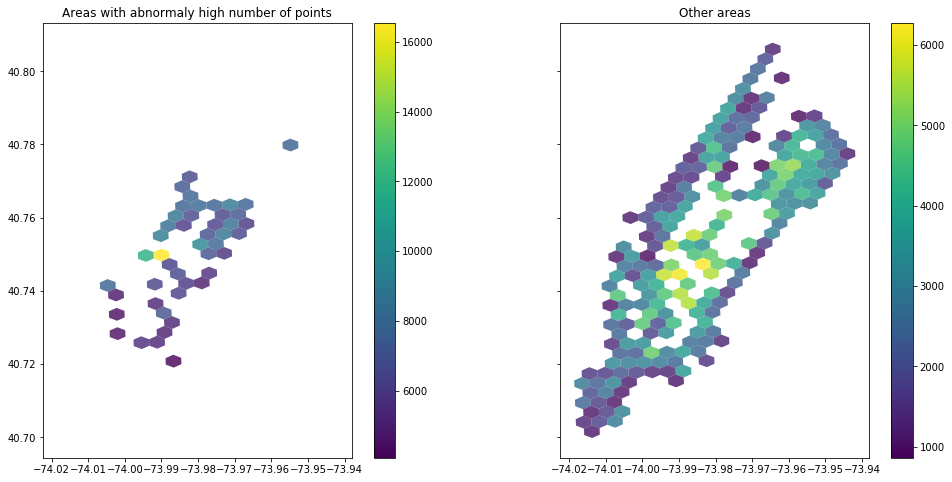

In [16]:
fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)

idx = data_clean.h3_res9.isin(daily_total[index_outliers].h3_res9)

plot_choropleth(data_clean[idx].h3_res9,
                'Areas with abnormaly high number of points', ax=ax1)

plot_choropleth(data_clean[~idx].h3_res9, 'Other areas', ax=ax2)

## Remove outliers

### Discussion
Here we need to make a decision about what to do with outliers. From business point of view, an area with high demand is potentially more profitable. But the data from this area can spoil a demand prediction model.

Common sense suggests that the real anomalies are not the areas with constant high demand but areas where demand increases sporadically. For example, after a football game demand jumped tenfold. This is an abnormal event and if there is no additional data (we don't have a calendar of events from the past) for explaining this, it would be better to remove such records from the dataset.

I would still **keep areas with high constant demand** and decide if I need to remove them on the prediction step. But I would **remove areas with sporadically high demand**.

In [17]:
counts = daily_total[index_outliers].h3_res9.value_counts()

counts.describe()

count     46.000
mean      25.587
std       38.191
min        1.000
25%        3.000
50%       12.500
75%       30.000
max      178.000
Name: h3_res9, dtype: float64

### Algorithm

1. Count the number of points per area per date (per day)
2. Detect outliers using MAD based method
3. Count how many times each area present in the outliers
4. Define two groups of outliers:
    1. Areas with high sporadic increases in the number of points, e.g. 3 times per month
    2. Areas with constantly high number of points, e.g. 28 times per month
5. Define a cut-off point between two groups of outliers
6. Remove areas with high constant demand from outliers
7. Remove outliers from the original dataset

As a cut-off point I will use 75th percentile - everything below are _real_ outliers

### Removal

In [58]:
# Step 1

res_column = 'h3_res9'

def total_per_day(data, column) -> pd.DataFrame:
    """Number of points per date per region"""

    daily_total = data_clean.groupby(
        [column, data.datetime.dt.date])[column].count()

    daily_total = daily_total.to_frame('total').reset_index()
    
    return daily_total

daily_total = total_per_day(data_clean, res_column)
daily_total.sample(3)

,h3_res9,datetime,total
39188,892a1072c03ffff,2015-02-19,12
14751,892a100d223ffff,2015-06-20,23
36786,892a10725b7ffff,2015-05-19,56


In [59]:
index_outliers = MAD_outliers(daily_total.total)
    
outlier_areas = daily_total[index_outliers][res_column].value_counts()

cutoff = np.percentile(outlier_areas.values, 75)

print(f'Cut-off: {cutoff}')

Cut-off: 36.5


In [60]:
# Step 3
# Step 4
# Step 5
# Step 6

def real_outliers_index(daily_total, column, pcnt=75) -> pd.Series:
    index_outliers = MAD_outliers(daily_total.total)
    
    outlier_areas = daily_total[index_outliers][column].value_counts()

    cutoff = np.percentile(outlier_areas.values, pcnt)
    
    print(f'Cut-off point: {cutoff}')
    print(f'Before cut-off: {outlier_areas.shape[0]}')

    cutoff_index = outlier_areas < cutoff
    real_outlier_areas = outlier_areas[cutoff_index].index

    print(f'After: {real_outlier_areas.shape[0]}')

    num_outliers = index_outliers.sum()
    print(f'Original number of outliers: {num_outliers}')

    o_idx = index_outliers & (daily_total[column].isin(list(real_outlier_areas)))
    
    num_outliers = o_idx.sum()
    print(f'Filtered number of outliers: {num_outliers}')
    
    return o_idx

In [62]:
%%time

# Step 7

# TODO: refactor ugly code below

def remove_outliers(data, daily_total, column):

    outliers_set = set([(i, j) for i, j in daily_total
                        [[column, 'datetime']].values.tolist()])

    r_idx = data.apply(lambda item: (item[column], pd.to_datetime(
        item.datetime).date()) in outliers_set, axis=1)
    
    return data[~r_idx]


daily_total = total_per_day(data_clean, res_column)

o_idx = real_outliers_index(daily_total, res_column)

print(f'Data before cleaning: {data_clean.shape[0]}')
data_cleanest = remove_outliers(data_clean, daily_total[o_idx], res_column)

print(f'Data after cleaning: {data_cleanest.shape[0]}')

data_cleanest.head(3)

Cut-off point: 36.5
Before cut-off: 50
After: 37
Original number of outliers: 1338
Filtered number of outliers: 318
Data before cleaning: 935256
Data after cleaning: 917031
CPU times: user 28.4 s, sys: 220 ms, total: 28.6 s
Wall time: 28.8 s


,datetime,lon,lat,h3_res8,h3_res9
60875772,2015-06-18 09:19:22,-73.964,40.765,882a100d69fffff,892a100d687ffff
26522107,2015-03-15 02:31:01,-73.989,40.722,882a1072cbfffff,892a1072ca3ffff
53427810,2015-05-28 11:00:01,-74.011,40.712,882a107289fffff,892a107289bffff


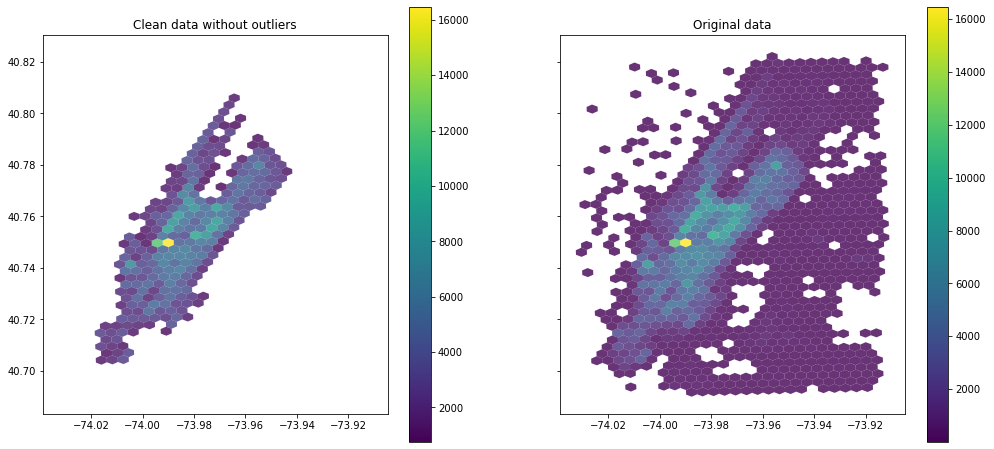

In [67]:
fig = plt.figure(figsize=(17, 8))
(ax1, ax2) = fig.subplots(1, 2, sharex=True, sharey=True)

plot_choropleth(data_cleanest[res_column], 'Clean data without outliers', ax=ax1)
plot_choropleth(data[res_column], 'Original data', ax=ax2);

# Export data

In [78]:
%%time 

print('-- Reading data --')
data_all = pd.read_feather('structured_data.feather')
print(f'Data size: {data_all.shape[0]}')

print('\n-- Calculating res 8 h3 index --')
data_all['h3_res8'] = point_h3_indexes(data_all, 8)

print('\n-- Calculating res 9 h3 index --')
res_column = 'h3_res9'
data_all[res_column] = point_h3_indexes(data_all, 9)

print('-- Removing noise --')
data_all = remove_noise(data_all)
print(f'Data size: {data_all.shape[0]}')

print('\n-- Removing outliers --')

daily_all_total = total_per_day(data_all, res_column)

o_idx = real_outliers_index(daily_all_total, res_column)

data_all = remove_outliers(data_all, daily_all_total[o_idx], res_column)
print(f'Data size: {data_all.shape[0]}')

file_name = 'clean_data.feather'

data_all = data_all.reset_index(drop=True)
print(f'\n-- Saving to {file_name} --')
data_all.to_feather(file_name)

-- Reading data --
Data size: 65221125

-- Calculating res 8 h3 index --

-- Calculating res 9 h3 index --
-- Removing noise --
Data size: 65091483

-- Removing outliers --
Cut-off point: 36.5
Before cut-off: 50
After: 37
Original number of outliers: 1338
Filtered number of outliers: 318
Data size: 64090334

-- Saving to clean_data.feather --
CPU times: user 1h 52min 30s, sys: 29min 24s, total: 2h 21min 55s
Wall time: 2h 58min 23s
